<a href="https://colab.research.google.com/github/Ayush245101/IndustryGPT-Specialized-LLM-Bot-Using-Pre-Trained-Models/blob/main/IndustryGPT_%E2%80%93_E%E2%80%91Commerce_Customer_Service_LLM_with_LoRA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#IndustryGPT – E‑Commerce Customer Service LLM with LoRA

###GitHub Link:- https://github.com/Ayush245101/IndustryGPT-Specialized-LLM-Bot-Using-Pre-Trained-Models

##Goals and Objectives

### High-Level Goal

Build a **scalable, domain-specific AI chatbot** for e-commerce customer support that can be trained and deployed efficiently on modest hardware using **LoRA parameter-efficient fine-tuning**.

### Specific Objectives

1. **Data Preparation & Preprocessing**
   - Clean and normalize both customer queries and agent responses.
   - Preserve important templates/variables (e.g., order IDs, invoice numbers).
   - Split data into training and test sets for evaluation.

2. **Model Adaptation with LoRA**
   - Start from a general-purpose T5 model.
   - Apply LoRA to selected attention layers to specialize the model on e-commerce support data.
   - Minimize the number of trainable parameters and memory footprint.

3. **Training & Evaluation**
   - Use a robust training loop with Hugging Face `Trainer`.
   - Monitor training and evaluation loss to ensure convergence.
   - Experiment with hyperparameters (epochs, learning rate, LoRA rank) for better quality.

4. **Interactive Inference**
   - Provide a simple Python interface (`chat_with_bot`) for testing.
   - Implement a user-friendly web UI using Streamlit to simulate a **customer chat widget**.

5. **Extensibility**
   - Keep the pipeline modular so that:
     - New data (e.g., more intents or languages) can be added easily.
     - LoRA adapters can be swapped or stacked for different domains.
     - Future extensions (multilingual support, intent classification, database integration) can be built on top of the same architecture.

##Project Description

### 1. Problem Domain

E-commerce platforms receive a high volume of repetitive customer support queries such as:

- "How do I track my order?"
- "Can I return this item?"
- "My payment failed, what should I do?"
- "How long does delivery take to my location?"

Manual handling of these queries is costly and does not scale well. A domain-specific language model fine-tuned on realistic conversation data can automate many of these interactions.

### 2. Technical Approach

1. **Model Choice**  
   - Base model: `t5-small` from Hugging Face Transformers.  
   - Reason: T5 is a **text-to-text** model, well-suited for turning user queries into natural-language responses.

2. **Text Preprocessing**
   - Convert to lowercase.
   - Strip leading/trailing spaces.
   - Collapse multiple spaces.
   - Preserve placeholders (e.g., `{{order number}}`) used in responses.
   - Remove rows with missing or invalid text.

3. **Prompt Formatting**
   - Inputs are converted to the format:
     ```text
     user: <cleaned customer query>
     bot:
     ```
   - Targets are the cleaned assistant responses.
   - This enforces a clear **role-based dialogue structure**.

4. **LoRA Fine-Tuning**
   - Use the `peft` library with a `LoraConfig`:
     - `task_type = SEQ_2_SEQ_LM` (for T5).
     - Apply LoRA to attention `q` and `v` projection layers.
     - Only a small number of **low-rank adapter parameters** are trained; the base model remains mostly frozen.
   - Benefits:
     - Lower GPU memory usage.
     - Faster training.
     - Easy to apply LoRA on top of other checkpoints.

5. **Training Setup**
   - Tokenization with padding and truncation.
   - Batch sizes and learning rate tuned for stability on `t5-small`.
   - Hugging Face `Trainer` with `TrainingArguments` for logging, evaluation, and checkpointing.
   - Model and tokenizer saved to `./finetuned-t5-lora-bot`.

6. **Deployment**
   - Inference helper `chat_with_bot(user_input)` for Colab/CLI.
   - A Streamlit app (`app.py`) that:
     - Loads the base T5 + LoRA adapters.
     - Provides a chat-style UI.
     - Generates responses for user queries in real time.
   - Optional: Use `pyngrok` to expose the app publicly from Colab.


In [1]:
# Colab / Environment Setup
!pip install -q transformers datasets sentencepiece peft accelerate bitsandbytes

import os
import re
import numpy as np
import pandas as pd
import torch

from datasets import Dataset, DatasetDict
from transformers import (
    T5ForConditionalGeneration,
    T5Tokenizer,
    TrainingArguments,
    Trainer
)

from peft import LoraConfig, get_peft_model, TaskType

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 13.4 MB/s eta 0:00:00


In [2]:

# 0. Device and Basic Config

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

os.environ["WANDB_DISABLED"] = "true"  # disable W&B in Colab by default

Using device: cuda


In [10]:

# 1. Load CSV
DATA_PATH = "/content/data (1).csv"

df = pd.read_csv(DATA_PATH)

print("Original columns:", df.columns.tolist())
df = df.rename(columns={"Human_Query": "human_query", "Assistant_Response": "assistant_response"})

Original columns: ['Human_Query', 'Assistant_Response']


In [11]:
# Basic Cleaning / Preprocessing
def clean_text(text: str) -> str:
    """
    Basic text cleaning:
    - Convert to string
    - Lowercase
    - Strip leading/trailing spaces
    - Collapse multiple spaces
    - Optionally keep placeholders like {{Order Number}} untouched
    """
    if not isinstance(text, str):
        text = "" if pd.isna(text) else str(text)
    text = text.strip()
    text = text.lower()
    # Keep double braces {{...}} (placeholders), but normalize spaces
    text = re.sub(r"\s+", " ", text)
    return text

# Drop rows with missing text
df = df.dropna(subset=["human_query", "assistant_response"]).reset_index(drop=True)

df["human_query_clean"] = df["human_query"].apply(clean_text)
df["assistant_response_clean"] = df["assistant_response"].apply(clean_text)

print("Sample cleaned rows:")
print(df[["human_query_clean", "assistant_response_clean"]].head())

Sample cleaned rows:
                                   human_query_clean  \
0   question about cancelling order {{order number}}   
1  i have a question about cancelling oorder {{or...   
2    i need help cancelling puchase {{order number}}   
3         i need to cancel purchase {{order number}}   
4  i cannot afford this order, cancel purchase {{...   

                            assistant_response_clean  
0  i've understood you have a question regarding ...  
1  i've been informed that you have a question ab...  
2  i can sense that you're seeking assistance wit...  
3  i understood that you need assistance with can...  
4  i'm sensitive to the fact that you're facing f...  


In [12]:
# Train/Test Split
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
split_idx = int(0.8 * len(df))
train_df = df.iloc[:split_idx]
test_df = df.iloc[split_idx:]

train_dataset = Dataset.from_pandas(
    train_df[["human_query_clean", "assistant_response_clean"]]
)
test_dataset = Dataset.from_pandas(
    test_df[["human_query_clean", "assistant_response_clean"]]
)

dataset = DatasetDict({"train": train_dataset, "test": test_dataset})
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['human_query_clean', 'assistant_response_clean'],
        num_rows: 22451
    })
    test: Dataset({
        features: ['human_query_clean', 'assistant_response_clean'],
        num_rows: 5613
    })
})


In [13]:
# 2. Load Base Model and Tokenizer

MODEL_NAME = "t5-small"

tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)
base_model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
base_model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [14]:
# 3. LoRA Configuration (Parameter-Efficient FT)

# apply LoRA to T5 (seq2seq) for text-to-text generation.
# This drastically reduces the number of trainable parameters.

lora_config = LoraConfig(
    task_type=TaskType.SEQ_2_SEQ_LM,  # T5 is seq2seq
    r=16,                             # LoRA rank
    lora_alpha=32,                    # LoRA scaling
    lora_dropout=0.1,                 # LoRA dropout
    target_modules=[
        "q", "v"  # typical for attention layers in T5 (q-proj, v-proj)
    ],
)

model = get_peft_model(base_model, lora_config)
model.print_trainable_parameters()  # Show how many params are trainable

trainable params: 589,824 || all params: 61,096,448 || trainable%: 0.9654


In [15]:
# 4. Tokenization / Preprocessing for Trainer

# We define a prompt format:
# "user: <question> \n bot:"
# so the model learns a conversational style.

max_input_length = 128
max_target_length = 128

def preprocess_function(batch):
    inputs = [
        f"user: {q}\nbot:"
        for q in batch["human_query_clean"]
    ]
    targets = batch["assistant_response_clean"]

    model_inputs = tokenizer(
        inputs,
        max_length=max_input_length,
        truncation=True,
        padding="max_length"
    )

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            targets,
            max_length=max_target_length,
            truncation=True,
            padding="max_length"
        )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_dataset = dataset.map(preprocess_function, batched=True, remove_columns=dataset["train"].column_names)
print(tokenized_dataset)


Map:   0%|          | 0/22451 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4118: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/5613 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 22451
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 5613
    })
})


In [16]:
# 5. Training Setup (with LoRA)


output_dir = "./results_lora_t5"

training_args = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=1e-4,
    num_train_epochs=5,
    logging_dir="./logs",
    logging_steps=100,
    # no evaluation_strategy / eval_strategy
    save_steps=500,
    save_total_limit=2,
    report_to="none"
)

# (Optional) simple loss metric wrapper
def compute_metrics(eval_pred):
    # We mainly track loss; you can add ROUGE, BLEU, etc. later
    logits, labels = eval_pred
    # Trainer already logs eval_loss; here we return empty for simplicity
    return {}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)


/tmp/ipython-input-522195772.py:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [17]:

# 6. Fine-Tune the Model with LoRA

trainer.train()

# Save the LoRA-adapted model (PEFT) and tokenizer
save_dir = "./finetuned-t5-lora-bot"
trainer.save_model(save_dir)
tokenizer.save_pretrained(save_dir)

print(f"Model + LoRA adapters saved to {save_dir}")

Step,Training Loss
100,5.605000
200,3.365200
300,2.890700
400,2.695200
500,2.605600
600,2.487900
700,2.418700
800,2.320400
900,2.362300
1000,2.280200


Model + LoRA adapters saved to ./finetuned-t5-lora-bot


In [24]:
# 7. Inference Helper (Chat Function)

# Reload model with LoRA for inference (for completeness)
from peft import PeftModel

base_model_infer = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
lora_model_infer = PeftModel.from_pretrained(base_model_infer, save_dir)
lora_model_infer.to(device)
lora_model_infer.eval()

def chat_with_bot(user_input: str, max_new_tokens: int = 64) -> str:
    prompt = f"user: {user_input.strip().lower()}\nbot:"
    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        padding=True,
        truncation=True
    ).to(device)

    with torch.no_grad():
        outputs = lora_model_infer.generate(
            **inputs,
            max_new_tokens=500,   # upper limit
            min_new_tokens=20,               # force at least some length
            num_beams=4,
            early_stopping=True,
            length_penalty=2.0,              # favors longer answers (>1.0)
            no_repeat_ngram_size=3,          # avoid short looping
        )

    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response.strip()

In [25]:
# Quick test
print("Test:", chat_with_bot("How do I track my order?"))

Test: thank you for reaching out! i'm here to assist you in tracking your order. to track your order, please follow these steps: 1. log in to your account on our website at website url. 2. navigate to the "order status" or "shop order" section. 3. look for the option that you would like to track the order. 4. click on the order name and the order number. 3. click on it. 4. look for a new order that will be sent to your customer support team. 4. if you have any questions or need further assistance.


In [28]:
# 8. Simple CLI Chat Loop in Colab

def chat_loop():
    print("🟢 LoRA T5 ChatBot is ready! Type 'exit' to quit.\n")
    while True:
        user_input = input("You: ")
        if user_input.lower().strip() in ["exit", "quit", "bye"]:
            print("Bot: Goodbye!")
            break
        reply = chat_with_bot(user_input)
        print(f"Bot: {reply}\n")

chat_loop()


🟢 LoRA T5 ChatBot is ready! Type 'exit' to quit.

You: check order
Bot: thank you for reaching out! i'm here to assist you in checking the order of your order. to check the order, please follow these steps: 1. log in to your account on our website. 2. navigate to the "orders" or "address" section. 3. look for the option to "check the order" or the "account" option. 3. click on the "check order" button. 4. click on it to view the order details. 4. select the order you want to check. 4. look for a new order.

You: bye
Bot: Goodbye!


In [29]:
# 9. Streamlit Web App + ngrok

# NOTE:
# - Below is a simplified app.py content that uses the LoRA model.

app_py_content = r"""
import streamlit as st
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
from peft import PeftModel

MODEL_NAME = 't5-small'
LORA_DIR = './finetuned-t5-lora-bot'

@st.cache_resource
def load_model():
    tokenizer = T5Tokenizer.from_pretrained(LORA_DIR)
    base_model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
    model = PeftModel.from_pretrained(base_model, LORA_DIR)
    model.eval()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    return model, tokenizer, device

model, tokenizer, device = load_model()

def generate_response(user_input: str, max_new_tokens: int = 64) -> str:
    prompt = f'user: {user_input.strip().lower()}\\nbot:'
    inputs = tokenizer(
        prompt,
        return_tensors='pt',
        padding=True,
        truncation=True
    ).to(device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=500,
            num_beams=4,
            early_stopping=True
        )

    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response.strip()

st.set_page_config(page_title='IndustryGPT - E-Commerce Support Bot', page_icon='🛍️', layout='centered')
st.title('🛍️ IndustryGPT - E-Commerce Customer Support Bot (LoRA-T5)')
st.markdown('Ask me anything about your orders, deliveries, returns, or payments!')

if 'chat_history' not in st.session_state:
    st.session_state.chat_history = []

user_input = st.text_input('You:')

if user_input:
    bot_response = generate_response(user_input)
    st.session_state.chat_history.append(('You', user_input))
    st.session_state.chat_history.append(('Bot', bot_response))

for sender, msg in st.session_state.chat_history:
    if sender == 'You':
        st.markdown(f'🧑‍💬 **{sender}**: {msg}')
    else:
        st.markdown(f'🤖 **{sender}**: {msg}')
"""

with open("app.py", "w") as f:
    f.write(app_py_content)

print("✅ app.py for Streamlit (LoRA model) written to disk.")


✅ app.py for Streamlit (LoRA model) written to disk.


In [30]:
# To run in Colab (manually):
!pip install streamlit pyngrok
from pyngrok import ngrok
ngrok.set_auth_token("368We17rnFRALcBxBrysVSWQykG_7v3cU8Xiv4oJEYV7vMvtj")
!streamlit run app.py &>/content/logs.txt &
public_url = ngrok.connect(8501)
print("Public URL:", public_url)

Public URL: NgrokTunnel: "https://promptingly-nonorthographical-albertha.ngrok-free.dev" -> "http://localhost:8501"


## WebApp Dashboad

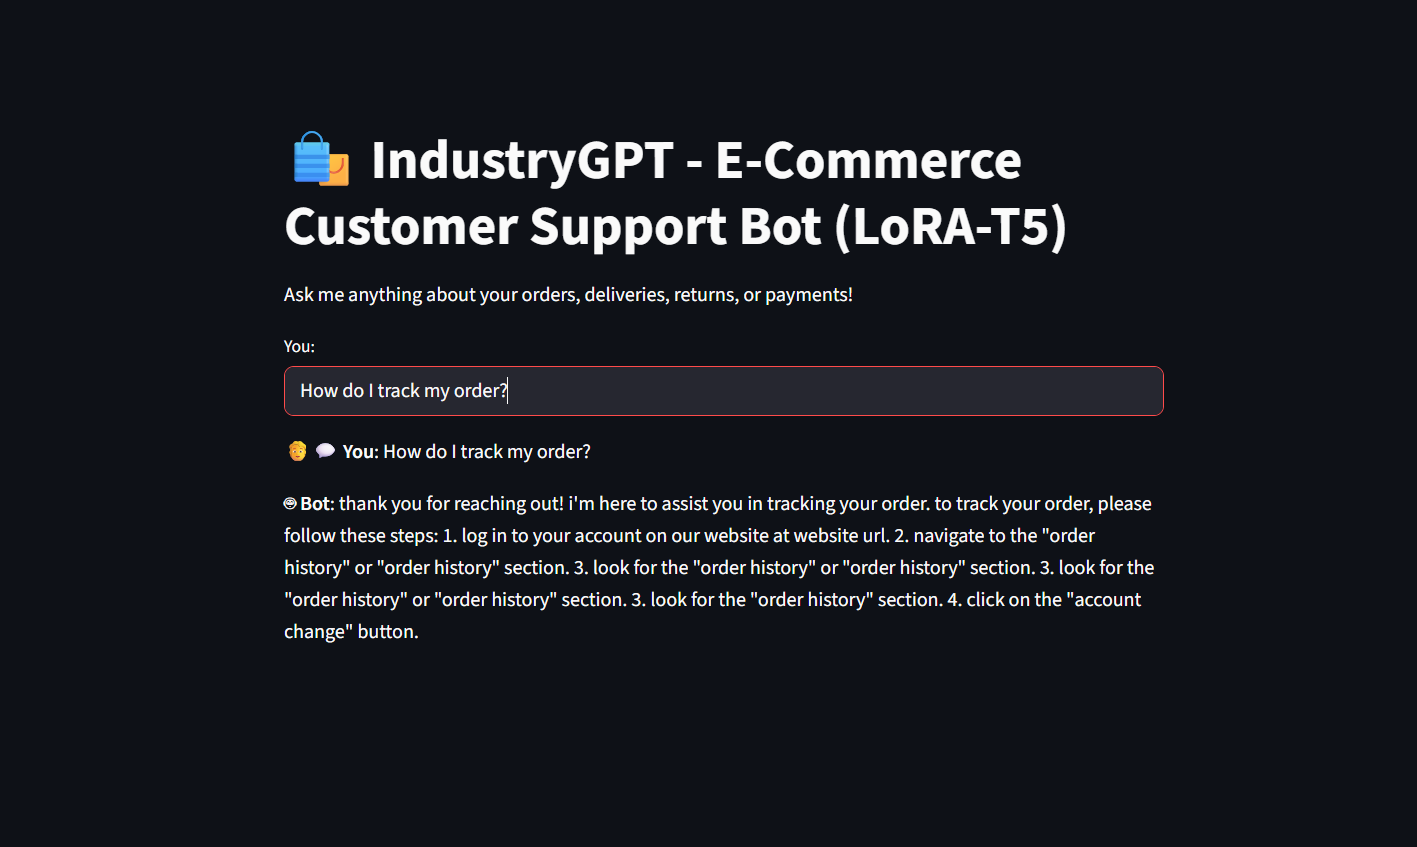

###Project Summary

This project implements **IndustryGPT**, a domain-specific **e‑commerce customer support chatbot**, by fine-tuning a **T5 transformer model** using **LoRA (Low‑Rank Adaptation)** and deploying it with a lightweight **Streamlit** web interface.

Instead of fine-tuning all model parameters, we use **parameter-efficient LoRA** on `t5-small`. This greatly reduces memory usage and training cost while still adapting the model to the specific language and style of e-commerce support. The model is trained on a custom dataset of paired *customer queries* and *assistant responses* (e.g., order tracking, returns, payments).

The training pipeline includes:

- **Text preprocessing**: lowercasing, trimming, de-noising, and consistent prompt formatting (`"user: ...\\nbot:"`).
- **Dataset preparation** with Hugging Face `datasets`.
- **LoRA fine-tuning** of T5 using the `peft` library and the `Trainer` API.
- **Evaluation and saving** of the adapted model and tokenizer.
- **Inference utilities** for testing in Colab and a **Streamlit UI** for real-time interaction.

The resulting model can generate fluent, contextually relevant responses to typical e-commerce support questions, making it a practical prototype for automating routine customer service.
